In [1]:
# The required imports
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

import yfinance as yf

In [2]:

# Using the module yfinance as yf the stock data of [COMPANY Name] from [Date] to [Date] is extracted and saved as df
df = yf.download('AAPL', start='2015-01-01', end='2022-12-31')
df.reset_index(inplace=True)
df.head()


[*********************100%%**********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-01-02,27.847500,27.860001,26.837500,27.332500,24.466452,212818400
1,2015-01-05,27.072500,27.162500,26.352501,26.562500,23.777189,257142000
2,2015-01-06,26.635000,26.857500,26.157499,26.565001,23.779428,263188400
3,2015-01-07,26.799999,27.049999,26.674999,26.937500,24.112871,160423600
4,2015-01-08,27.307501,28.037500,27.174999,27.972500,25.039341,237458000


In [3]:
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
2009,2022-12-23,130.919998,132.419998,129.639999,131.860001,131.127060,63814900
2010,2022-12-27,131.380005,131.410004,128.720001,130.029999,129.307236,69007800
2011,2022-12-28,129.669998,131.029999,125.870003,126.040001,125.339409,85438400
2012,2022-12-29,127.989998,130.479996,127.730003,129.610001,128.889572,75703700
2013,2022-12-30,128.410004,129.949997,127.430000,129.929993,129.207779,77034200


<ipython-input-4-e31c2fd3be9e>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  annual_volatility = annual_volatility.append({'Year': year, 'Volatility': volatility}, ignore_index=True)
<ipython-input-4-e31c2fd3be9e>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  annual_volatility = annual_volatility.append({'Year': year, 'Volatility': volatility}, ignore_index=True)
<ipython-input-4-e31c2fd3be9e>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  annual_volatility = annual_volatility.append({'Year': year, 'Volatility': volatility}, ignore_index=True)
<ipython-input-4-e31c2fd3be9e>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  an

Volatility for 2015: 26.77%
Volatility for 2016: 23.42%
Volatility for 2017: 17.68%
Volatility for 2018: 28.69%
Volatility for 2019: 26.23%
Volatility for 2020: 46.80%
Volatility for 2021: 25.02%
Volatility for 2022: 35.60%


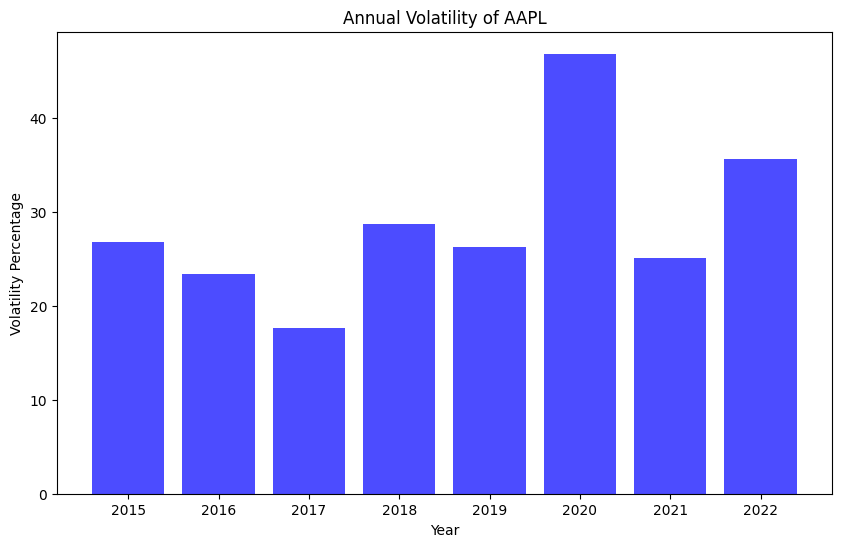

In [4]:
# checking volatility
# Create a new column for the year
df['Year'] = df['Date'].dt.year

# Initializing an empty DataFrame to store annual volatility
annual_volatility = pd.DataFrame(columns=['Year', 'Volatility'])

# Looping through each year, calculating volatility, and storing it in the DataFrame
for year, group in df.groupby('Year'):
    group['PrevClose'] = group['Close'].shift(1)
    group['Return'] = (group['Close'] - group['PrevClose']) / group['PrevClose']
    std_dev_daily = group['Return'].std()
    trading_days = len(group['Date'])
    volatility = std_dev_daily * np.sqrt(trading_days)
    annual_volatility = annual_volatility.append({'Year': year, 'Volatility': volatility}, ignore_index=True)

    print(f"Volatility for {year}: {volatility * 100:.2f}%")

# Create a bar plot for annual volatility
plt.figure(figsize=(10, 6))
plt.bar(annual_volatility['Year'], annual_volatility['Volatility'] * 100, color='blue', alpha=0.7)
plt.xlabel('Year')
plt.ylabel('Volatility Percentage')
plt.title('Annual Volatility of AAPL')
plt.show()



In [5]:
# storing the close data into stock_data
stock_data = df['Close'].values.reshape(-1, 1)


In [6]:
# Preprocessing
# Normalizing the data to an range between 0 and 1 using min-max scaling
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(stock_data)

In [10]:
# Defining parameters
time_steps = 10  # number of time steps to me considered for prediction
num_feature = 1  # Number of features
epochs = 50
batch_size = 32

# Preparing input sequences and labels
X, y = [], []

for i in range(len(normalized_data) - time_steps):
    X.append(normalized_data[i:i+time_steps, 0])
    y.append(normalized_data[i+time_steps, 0])

X, y = np.array(X), np.array(y)

# Preprocessing
# Reshaping the data for LSTM input

X = X.reshape((X.shape[0], X.shape[1], num_feature))

In [11]:
# Build LSTM model that comprises a single LSTM layer with ReLU activation, followed by a Dense layer for output
model = Sequential()
model.add(LSTM(units=50, activation='relu', input_shape=(time_steps, num_feature)))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Preprocessing
# Spliting the data into training and testing sets
split = int(0.8 * len(X))
X_train, X_test, y_train, y_test = X[:split], X[split:], y[:split], y[split:]





In [12]:
# Training the model
model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=2)

# Making predictions
predictions = model.predict(X_test)

Epoch 1/50
51/51 - 2s - loss: 0.0227 - 2s/epoch - 43ms/step
Epoch 2/50
51/51 - 0s - loss: 8.4862e-04 - 331ms/epoch - 6ms/step
Epoch 3/50
51/51 - 0s - loss: 3.2603e-04 - 328ms/epoch - 6ms/step
Epoch 4/50
51/51 - 0s - loss: 2.3061e-04 - 348ms/epoch - 7ms/step
Epoch 5/50
51/51 - 0s - loss: 2.2934e-04 - 316ms/epoch - 6ms/step
Epoch 6/50
51/51 - 0s - loss: 2.1795e-04 - 288ms/epoch - 6ms/step
Epoch 7/50
51/51 - 0s - loss: 2.0001e-04 - 314ms/epoch - 6ms/step
Epoch 8/50
51/51 - 0s - loss: 2.0149e-04 - 291ms/epoch - 6ms/step
Epoch 9/50
51/51 - 0s - loss: 2.0491e-04 - 327ms/epoch - 6ms/step
Epoch 10/50
51/51 - 0s - loss: 2.0089e-04 - 336ms/epoch - 7ms/step
Epoch 11/50
51/51 - 0s - loss: 1.8557e-04 - 343ms/epoch - 7ms/step
Epoch 12/50
51/51 - 0s - loss: 1.8118e-04 - 333ms/epoch - 7ms/step
Epoch 13/50
51/51 - 0s - loss: 1.7786e-04 - 317ms/epoch - 6ms/step
Epoch 14/50
51/51 - 0s - loss: 1.7221e-04 - 322ms/epoch - 6ms/step
Epoch 15/50
51/51 - 0s - loss: 1.6691e-04 - 312ms/epoch - 6ms/step
Epoch 16/5

In [13]:
# Preprocessing
# Inverse transformthe predictions to original scale
predictions = scaler.inverse_transform(predictions)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

In [14]:

# Evaluating the model
test_loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')

13/13 [==============================] - 0s 6ms/step - loss: 23264.3535
Test Loss: 23264.353515625


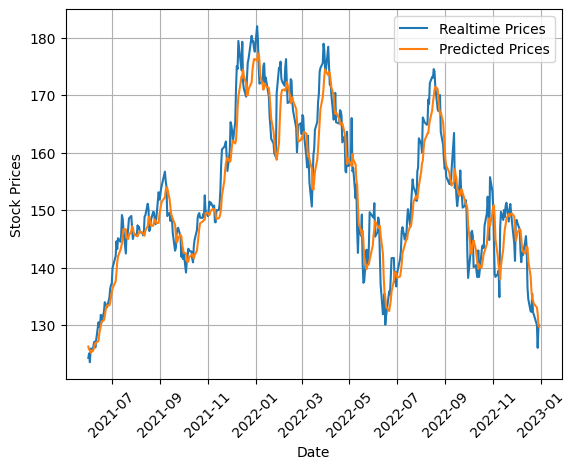

In [15]:
# # Visualizing the predictions
dates = df['Date'].values
plt.plot(dates[-len(y_test):], y_test, label='Realtime Prices')
plt.plot(dates[-len(predictions):], predictions, label='Predicted Prices')
plt.xlabel('Date')
plt.ylabel('Stock Prices')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.show()